In [1]:
import osmnx as ox
import pandana
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

In [2]:
# Select city (COP, HEL, WAR)
city = 'COP'

if city == 'COP':
    cityname = 'Copenhagen, Denmark'
    minx, miny, maxx, maxy = 12.42000, 55.61000, 12.65000, 55.78000
elif city == 'HEL':
    cityname = 'Helsinki, Finland'
    minx, miny, maxx, maxy = 24.82345, 60.14084, 25.06404, 60.29496
elif city == 'WAR':
    cityname = 'Warsaw, Poland'
    minx, miny, maxx, maxy = 20.79057, 52.09901, 21.31300, 52.38502

In [3]:
# Get graph by geocoding
try:
    graph = ox.graph_from_place(cityname, network_type="walk")
    ignore_geocoding = False
    
# Get graph based on bbox if geocoding fails (copenhagen has no polygon on nominatim)
except ValueError:
    graph = ox.graph_from_bbox(maxy, miny, maxx, minx, network_type="walk")
    ignore_geocoding = True
    
graph = ox.projection.project_graph(graph, to_crs=3035)

In [5]:
# Max time to walk in minutes (no routing to nodes further than this)
walk_time = 15

# Walking speed
walk_speed = 4.5

# Set a uniform walking speed on every edge
for u, v, data in graph.edges(data=True):
    data['speed_kph'] = walk_speed

graph = ox.add_edge_travel_times(graph)

# Extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)
nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

In [6]:
# Select pois based on osm tags
tags = {
    'amenity':[
        'cafe',
        'bar',
        'pub',
        'restaurant'
    ],
    'shop':[
        'bakery',
        'convenience',
        'supermarket',
        'mall',
        'department_store',
        'clothes',
        'fashion',
        'shoes'
    ],
    'leisure':[
        'fitness_centre'
    ]
}

# Get amentities from place/bbox
if ignore_geocoding == True:
    amenities = ox.geometries.geometries_from_bbox(
        maxy, miny, maxx, minx,
        tags=tags
    )
    
else:
    amenities = ox.geometries.geometries_from_place(
        cityname,
        tags=tags
    )
    
# Project amenities
amenities = amenities.to_crs(epsg=3035)

In [7]:
# Save as gpkg
#amenities_point = amenities[amenities['geometry'].apply(lambda x: x.type=='Point')]
#amenities_point.to_file('amenities_'+city+'.gpkg', driver='GPKG')

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Construct the pandana network model
network = pandana.Network(
    node_x=nodes['x'],
    node_y=nodes['y'], 
    edge_from=edges['u'],
    edge_to=edges['v'],
    edge_weights=edges[['travel_time']]
)

# Extract centroids from the amenities' geometries
centroids = amenities.centroid

In [9]:
# Specify a max travel distance for analysis
# Minutes -> seconds
maxdist = walk_time * 60

# Set the amenities' locations on the network
network.set_pois(
    category='pois',
    maxdist=maxdist,
    maxitems=10,
    x_col=centroids.x, 
    y_col=centroids.y
)

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [10]:
# calculate travel time to 10 nearest amenities from each node in network
distances = network.nearest_pois(
    distance=maxdist,
    category='pois',
    num_pois=10
)

distances.astype(int).head()

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
0,94,94,94,97,109,109,109,117,117,117
1,70,70,70,106,106,106,106,130,132,132
2,54,54,54,77,77,77,77,100,118,118
3,515,577,577,577,656,773,828,876,876,876
4,31,93,93,93,171,288,344,392,392,392


/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


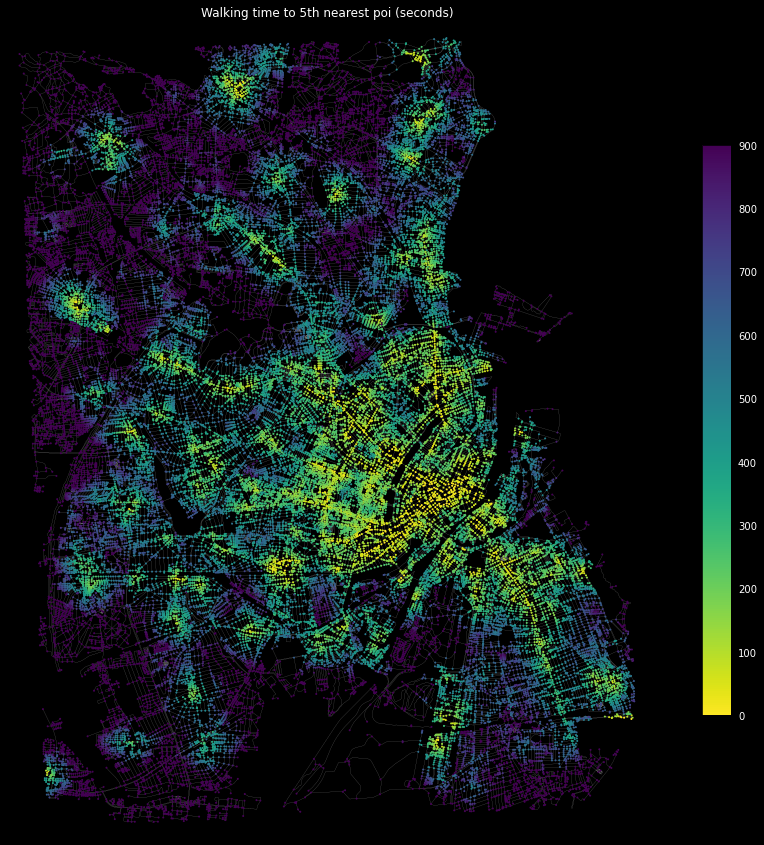

In [37]:
# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
fig.set_facecolor((0,0,0))

# Plot distance
ox.plot_graph(
    graph,
    ax=ax,
    node_size=0,
    edge_linewidth=0.1,
    edge_color='gray',
    show=False,
    close=False
)

# Plot distance to nearest amenity
scatter = ax.scatter(
    x=nodes['x'],
    y=nodes['y'], 
    c=distances[5],
    s=1,
    cmap='viridis_r'
)

ax.set_title(f'Walking time to 5th nearest poi (seconds)', color='w')
cb = plt.colorbar(scatter, shrink=0.7)
cb.ax.yaxis.set_tick_params(color='none')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='w')

plt.show()

In [12]:
# check data
distances.head()

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
0,94.300003,94.300003,94.300003,97.099998,109.500000,109.500000,109.500000,117.400002,117.400002,117.400002
1,70.900002,70.900002,70.900002,106.099998,106.099998,106.099998,106.099998,130.600006,132.899994,132.899994
2,54.000000,54.000000,54.000000,77.099998,77.099998,77.099998,77.099998,100.699997,118.400002,118.400002
3,515.900024,577.900024,577.900024,577.900024,656.000000,773.000000,828.700012,876.700012,876.700012,876.700012
4,31.400000,93.400002,93.400002,93.400002,171.500000,288.500000,344.200012,392.200012,392.200012,392.200012


In [13]:
nodes.head()

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,x,y
osmid,,
0,4.482308e+06,3.621702e+06
1,4.482340e+06,3.621729e+06
2,4.482277e+06,3.621705e+06
3,4.482074e+06,3.620364e+06
4,4.482530e+06,3.620763e+06


In [14]:
# Get simplified nodes with wgs coords for output csv
graph_wgs = ox.projection.project_graph(graph, to_crs=4326)
nodes_wgs = ox.graph_to_gdfs(graph_wgs, edges=False)[['x', 'y']]

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Join travel time info to nodes
walk_access = nodes.join(distances, on='osmid', how='left')
walk_access_wgs = nodes_wgs.join(distances, on='osmid', how='left')

In [16]:
walk_access_wgs.head()

,x,y,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,,,
0,12.562955,55.673922,94.300003,94.300003,94.300003,97.099998,109.500000,109.500000,109.500000,117.400002,117.400002,117.400002
1,12.563476,55.674155,70.900002,70.900002,70.900002,106.099998,106.099998,106.099998,106.099998,130.600006,132.899994,132.899994
2,12.562458,55.673955,54.000000,54.000000,54.000000,77.099998,77.099998,77.099998,77.099998,100.699997,118.400002,118.400002
21649,12.563817,55.674226,51.700001,51.700001,51.700001,86.900002,86.900002,86.900002,86.900002,111.400002,136.899994,136.899994
375,12.563455,55.672945,0.000000,55.000000,61.400002,61.400002,61.400002,61.400002,95.300003,95.300003,95.300003,97.300003


In [17]:
# Save as CSV
walk_access_wgs.to_csv('walk_access_'+city+'.csv', encoding='utf-8')

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
